# Pdf extraction with unstructured.io

Using the [Yolox paper](https://arxiv.org/pdf/2107.08430.pdf) as a guinea pig for extraction.

In [22]:
from unstructured.chunking.title import chunk_by_title
from unstructured.staging.base import dict_to_elements, elements_to_text, convert_to_dict
import polars as pl
from polars import col
import torch

In [23]:
import unstructured
from unstructured.partition.pdf import partition_pdf

In [2]:
torch.cuda.is_available()

False

Not even using a GPU

In [44]:
def display_df(df: pl.DataFrame, *, n_rows=100, fmt_str_lengths=1000, tbl_width_chars=1000):
    with pl.Config(tbl_rows=n_rows, tbl_cols=-1, fmt_str_lengths=fmt_str_lengths, tbl_width_chars=tbl_width_chars):
        display(df)

In [36]:
out_yolox = partition_pdf("2107.08430.pdf", strategy="hi_res", hi_res_model_name="yolox", include_page_breaks=True)

This took about 1m on my crappy 5 year old laptop

In [38]:
out_fast = partition_pdf("2107.08430.pdf", strategy="fast", include_page_breaks=True)

This is speedy, 1.5s, as it says on the tin

In [39]:
df_yolox = pl.DataFrame(convert_to_dict(out_yolox))
df_fast = pl.DataFrame(convert_to_dict(out_fast))

In [55]:
df_yolox.height, df_fast.height

(132, 298)

The approaches give quite different numbers of elements

In [45]:
display_df(df_yolox["type"].value_counts().sort("type"))

type,count
str,u32
"""FigureCaption""",7
"""Footer""",7
"""Formula""",1
"""Header""",1
"""Image""",4
"""ListItem""",33
"""NarrativeText""",49
"""PageBreak""",6
"""Table""",6


In [46]:
display_df(df_fast["type"].value_counts().sort("type"))

type,count
str,u32
"""ListItem""",12
"""NarrativeText""",89
"""PageBreak""",7
"""Title""",69
"""UncategorizedText""",121


When you use yolox you get a lot more categories

## Is the table category accurate?

In [33]:
for row in df_yolox.filter(col("type") == "Table")["text"]:
    print(row)

Models Coupled Head Decoupled Head Vanilla YOLO End-to-end YOLO 38.5 34.3 (-4.2) 39.6 38.8 (-0.8)
Methods AP (%) Parameters GFLOPs Latency FPS YOLOv3-ultralytics2 44.3 63.00 M 157.3 10.5 ms 95.2 YOLOv3 baseline +decoupled head +strong augmentation +anchor-free +multi positives +SimOTA +NMS free (optional) 38.5 39.6 (+1.1) 42.0 (+2.4) 42.9 (+0.9) 45.0 (+2.1) 47.3 (+2.3) 46.5 (-0.8) 63.00 M 63.86 M 63.86 M 63.72 M 63.72 M 63.72 M 67.27 M 157.3 186.0 186.0 185.3 185.3 185.3 205.1 10.5 ms 11.6 ms 11.6 ms 11.1 ms 11.1 ms 11.1 ms 13.5 ms 95.2 86.2 86.2 90.1 90.1 90.1 74.1
Models AP (%) Parameters GFLOPs Latency YOLOv5-S YOLOX-S 36.7 39.6 (+2.9) 7.3 M 9.0 M 17.1 26.8 8.7 ms 9.8 ms YOLOv5-M 44.5 YOLOX-M 46.4 (+1.9) 21.4 M 25.3 M 51.4 73.8 11.1 ms 12.3 ms YOLOv5-L YOLOX-L 48.2 50.0 (+1.8) 47.1 M 54.2 M 115.6 155.6 13.7 ms 14.5 ms YOLOv5-X 50.4 YOLOX-X 51.2 (+0.8) 87.8 M 99.1 M 219.0 281.9 16.0 ms 17.3 ms
Models AP (%) Parameters GFLOPs YOLOv4-Tiny [30] PPYOLO-Tiny YOLOX-Tiny 21.7 22.7 32.8 (+10

These indeed seem to correspond to the text in the table

## Are the titles accurate?

In [35]:
for row in df_yolox.filter(col("type") == "Title")["text"]:
    print(row)

YOLOX: Exceeding YOLO Series in 2021
Zheng Ge∗ Songtao Liu∗† Feng Wang Zeming Li Jian Sun
Megvii Technology {gezheng, liusongtao, wangfeng02, lizeming, sunjian}@megvii.com
Abstract
1. Introduction
2. YOLOX
2.1. YOLOX-DarkNet53
2https://github.com/ultralytics/yolov3 3https://github.com/RangiLyu/nanodet
FPN
thus train all the following models from scratch.
2.2. Other Backbones
3. Comparison with the SOTA
4. 1st Place on Streaming Perception Challenge (WAD at CVPR 2021)
Acknowledge
References
5. Conclusion


Mostly good, some places it's wrong but in an understandable way

## What kind of metadata do we get?

In [50]:
df_yolox.sample(1, seed=42)["metadata"][0]

{'detection_class_prob': 0.9526500105857849,
 'coordinates': {'points': [[138.61550903320312, 575.0453377777786],
   [138.61550903320312, 1035.1983642578125],
   [798.3045654296875, 1035.1983642578125],
   [798.3045654296875, 575.0453377777786]],
  'system': 'PixelSpace',
  'layout_width': 1700,
  'layout_height': 2200},
 'last_modified': '2024-04-13T14:04:15',
 'filetype': 'application/pdf',
 'languages': ['eng'],
 'page_number': 2,
 'filename': '2107.08430.pdf',
 'parent_id': None}

In [54]:
df_yolox.filter(col("type")=="NarrativeText")["metadata"][0]

{'detection_class_prob': 0.9438773989677429,
 'coordinates': {'points': [[139.2, 1266.9449494444443],
   [139.2, 1892.3771716666668],
   [800.0421142578125, 1892.3771716666668],
   [800.0421142578125, 1266.9449494444443]],
  'system': 'PixelSpace',
  'layout_width': 1700,
  'layout_height': 2200},
 'last_modified': '2024-04-13T14:04:15',
 'filetype': 'application/pdf',
 'languages': ['eng'],
 'page_number': 1,
 'filename': '2107.08430.pdf',
 'parent_id': 'ebf237f98f05c4390df1cde93629de8d'}

Class probabilities are quite interesting

In [61]:
df_yolox.filter(col("type") == "Title")[7]["metadata"][0]

{'detection_class_prob': None,
 'coordinates': {'points': [[169.36388888888888, 1927.1432266666668],
   [169.36388888888888, 1978.2544575],
   [670.5395, 1978.2544575],
   [670.5395, 1927.1432266666668]],
  'system': 'PixelSpace',
  'layout_width': 1700,
  'layout_height': 2200},
 'last_modified': '2024-04-13T14:04:15',
 'filetype': 'application/pdf',
 'languages': ['eng'],
 'page_number': 2,
 'filename': '2107.08430.pdf',
 'parent_id': None}

In [64]:
df_yolox = df_yolox.with_columns(
    col("metadata").struct.field("detection_class_prob")
)

In [77]:
n_null_detection_class_probas = df_yolox["detection_class_prob"].is_null().sum()
n_null_detection_class_probas, df_yolox.height

(18, 132)

In [74]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, '# elements null prob = 18; total elements = 132')

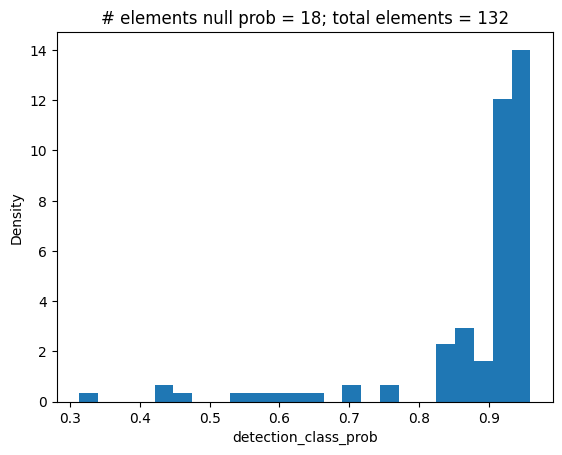

In [78]:
fig, ax = plt.subplots()
ax.hist(df_yolox["detection_class_prob"], bins="auto", density=True);
ax.set_xlabel("detection_class_prob")
ax.set_ylabel("Density")
ax.set_title(f"# elements null prob = {n_null_detection_class_probas}; total elements = {df_yolox.height}")

## Make "clean" narrative text chunks

In [80]:
display_df(df_yolox["type"].value_counts().sort("type"))

type,count
str,u32
"""FigureCaption""",7
"""Footer""",7
"""Formula""",1
"""Header""",1
"""Image""",4
"""ListItem""",33
"""NarrativeText""",49
"""PageBreak""",6
"""Table""",6


In [81]:
retained_types = {"NarrativeText", "PageBreak", "Title"}

In [82]:
df_yolox_clean = df_yolox.filter(
    col("type").is_in(retained_types) & col("detection_class_prob").is_not_null()
)

In [84]:
df_yolox_clean.head()

type,element_id,text,metadata,detection_class_prob
str,str,str,struct[8],f64
"""Title""","""2e8cad76afca6d…","""YOLOX: Exceedi…","{0.564603,{[[464.045593, 293.292099], [464.045593, 333.564758], … [1186.208984, 293.292099]],""PixelSpace"",1700,2200},""2024-04-13T14:04:15"",""application/pdf"",[""eng""],1,""2107.08430.pdf"",null}",0.564603
"""Title""","""a7bf4337638319…","""Zheng Ge∗ Song…","{0.6068,{[[360.803802, 400.078054], [360.803802, 474.714813], … [1290.02063, 400.078054]],""PixelSpace"",1700,2200},""2024-04-13T14:04:15"",""application/pdf"",[""eng""],1,""2107.08430.pdf"",null}",0.6068
"""Title""","""ebf237f98f05c4…","""Abstract""","{0.827948,{[[405.541667, 1193.431769], [405.541667, 1226.640658], … [530.184875, 1193.431769]],""PixelSpace"",1700,2200},""2024-04-13T14:04:15"",""application/pdf"",[""eng""],1,""2107.08430.pdf"",null}",0.827948
"""NarrativeText""","""c4dabd97240aae…","""In this report…","{0.943877,{[[139.2, 1266.944949], [139.2, 1892.377172], … [800.042114, 1266.944949]],""PixelSpace"",1700,2200},""2024-04-13T14:04:15"",""application/pdf"",[""eng""],1,""2107.08430.pdf"",""ebf237f98f05c4390df1cde93629de8d""}",0.943877
"""NarrativeText""","""901bbffb419c52…","""researchers in…","{0.922953,{[[857.281494, 1164.156061], [857.281494, 1292.044434], … [1521.846069, 1164.156061]],""PixelSpace"",1700,2200},""2024-04-13T14:04:15"",""application/pdf"",[""eng""],1,""2107.08430.pdf"",""ebf237f98f05c4390df1cde93629de8d""}",0.922953


In [ ]:
chunks_yolox = chunk_by_title(
    out_yolox,
    combine_text_under_n_chars=100,
    max_characters=3000,
)

chunks_fast = chunk_by_title(
    out_fast,
    combine_text_under_n_chars=100,
    max_characters=3000,
)

In [9]:
print(elements_to_text(out_yolox))

| INVESTIGATION
Mitochondrial Network State Scales mtDNA Genetic Dynamics
Juvid Aryaman,*,†,‡ Charlotte Bowles,§ Nick S. Jones,*,**,1 and Iain G. Johnston††,‡‡,1 *Department of Mathematics and **Engineering and Physical Sciences Research Council Centre for the Mathematics of Precision Healthcare, Imperial College London, SW7 2AZ, United Kingdom; †Department of Clinical Neurosciences, University of Cambridge, CB2 0QQ, United Kingdom; ‡Medical Research Council Mitochondrial Biology Unit, University of Cambridge, CB2 0XY, United Kingdom; §School of Biosciences, University of Birmingham, B15 2TT, United Kingdom; ††Faculty of Mathematics and Natural Sciences, University of Bergen, 5007, Norway; and ‡‡Alan Turing Institute, London NW1 2DB, United Kingdom ORCID IDs: 0000-0002-2605-052X (J.A.); 0000-0002-4083-972X (N.S.J.); 0000-0001-8559-3519 (I.G.J.)
ABSTRACT Mitochondrial DNA (mtDNA) mutations cause severe congenital diseases but may also be associated with healthy aging. mtDNA is stochasti